# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

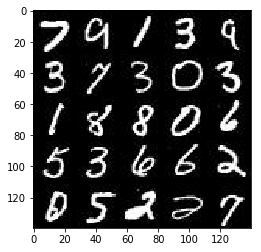

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

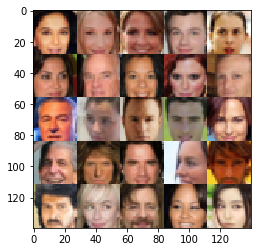

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, (), name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Conv 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # Conv 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Conv 3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Start convolutional transpose stack
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        
        # Logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=2, padding='same')
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of every 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 12.0584
Epoch 1/2... Discriminator Loss: 1.7733... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 0.5798... Generator Loss: 8.5929
Epoch 1/2... Discriminator Loss: 2.1851... Generator Loss: 0.3274
Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 3.7770
Epoch 1/2... Discriminator Loss: 1.7503... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 2.7627... Generator Loss: 6.8966
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 1.7077
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 2.1956
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 3.3021


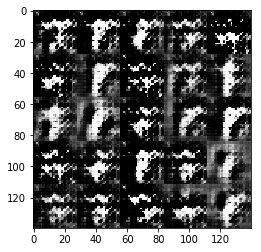

Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 3.0524
Epoch 1/2... Discriminator Loss: 2.8730... Generator Loss: 7.5023
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.7815
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 1.6846
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.4269
Epoch 1/2... Discriminator Loss: 0.6641... Generator Loss: 1.8846
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 3.1731


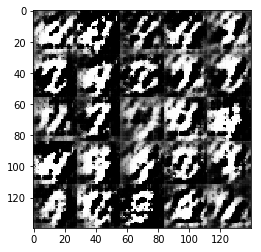

Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 2.1510
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 3.2373
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 3.3433
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 3.2205
Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.8444
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 2.3684
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 2.1046
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 3.1147
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 0.8602


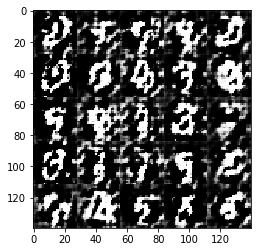

Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 4.6083
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 1.7964
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 2.0387
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 2.5364
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.8970
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.0964
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 3.0382
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 1.3026
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 2.4092
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.7143


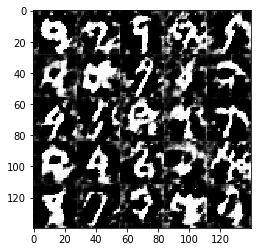

Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 2.7706
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 3.1362
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 2.6338
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 3.4412
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 1.4124


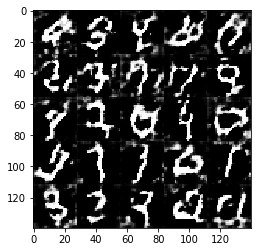

Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 1.8894
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.6064
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 2.2927
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.9595
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 0.9250


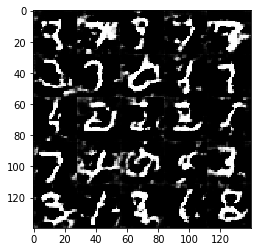

Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 2.6754
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.2408
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.9000... Generator Loss: 0.3369


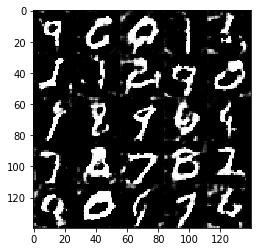

Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.7576
Epoch 1/2... Discriminator Loss: 2.6963... Generator Loss: 0.1932
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.4176


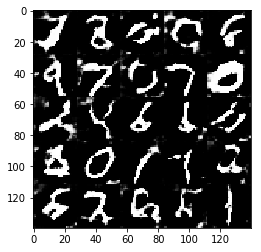

Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.9774
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 1.5468
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 2.1268
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.7650
Epoch 1/2... Discriminator Loss: 1.9320... Generator Loss: 0.2900
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 1.5582
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.7035


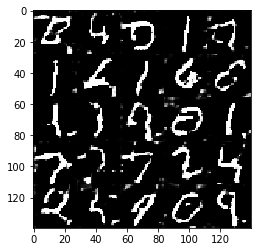

Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 2.8757
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 0.9660... Generator Loss: 0.9938
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 1.8959
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 3.0803
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.1790


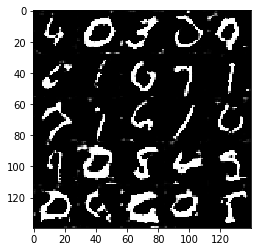

Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.4869
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.6005... Generator Loss: 0.4248
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 1.7603
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.1105
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.0977


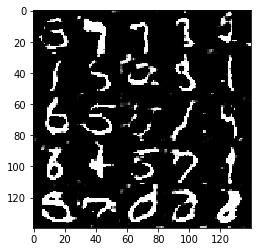

Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 1.6220
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 2.2420
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 2.5362
Epoch 2/2... Discriminator Loss: 1.9211... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 1.1164


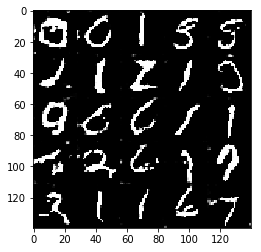

Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 1.6018
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.2925... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 1.7232
Epoch 2/2... Discriminator Loss: 1.8196... Generator Loss: 0.3314
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.3644


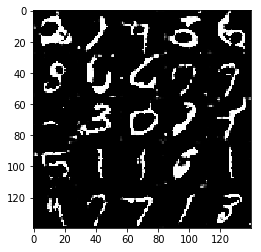

Epoch 2/2... Discriminator Loss: 1.8139... Generator Loss: 0.3320
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.7300
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.5390
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 2.2686
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.6191
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.5338


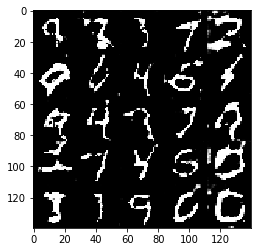

Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 2.0805
Epoch 2/2... Discriminator Loss: 1.5561... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.6763
Epoch 2/2... Discriminator Loss: 1.8533... Generator Loss: 2.5451
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 1.1944
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.5802


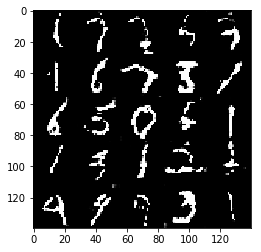

Epoch 2/2... Discriminator Loss: 1.6207... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.0659
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.7320... Generator Loss: 0.4288
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 1.3108
Epoch 2/2... Discriminator Loss: 1.8396... Generator Loss: 0.3608
Epoch 2/2... Discriminator Loss: 1.6172... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.0634


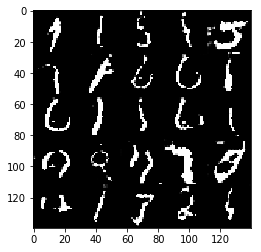

Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.8027
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 1.9055
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 2.5576
Epoch 2/2... Discriminator Loss: 1.6212... Generator Loss: 0.4608
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 1.6092... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 1.9761


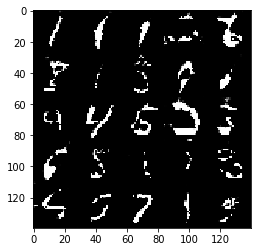

Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.6067
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.4908
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.3384
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.3451
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 2.3583
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.2561
Epoch 2/2... Discriminator Loss: 2.4947... Generator Loss: 0.2855
Epoch 2/2... Discriminator Loss: 1.1677... Generator Loss: 0.8183


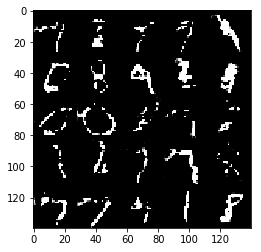

Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 2.1057


IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 4.5456
Epoch 1/1... Discriminator Loss: 2.5283... Generator Loss: 0.2959
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 2.8055
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 3.0985
Epoch 1/1... Discriminator Loss: 2.6896... Generator Loss: 6.4098
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 2.7182


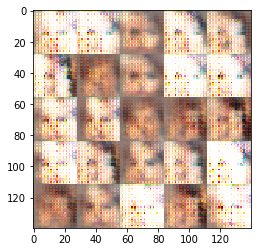

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 2.4795
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.5109
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.8453
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 2.0696


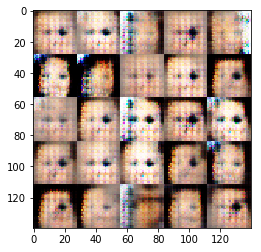

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 2.3813
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7451


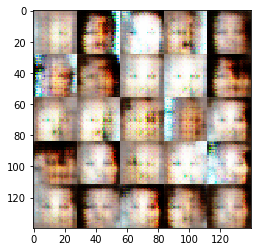

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 1.8699... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.8144... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 2.0565
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.0001


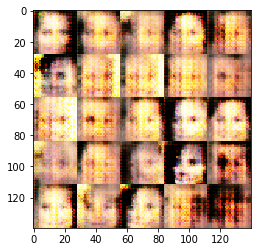

Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 2.2863
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.1323


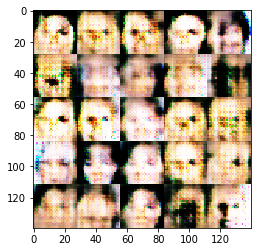

Epoch 1/1... Discriminator Loss: 2.6714... Generator Loss: 4.3354
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 1.9773
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.6117


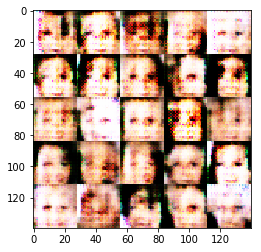

Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.9497... Generator Loss: 3.1582
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.4693


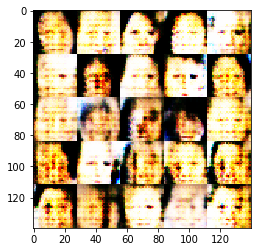

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.7427... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 2.8475
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6862


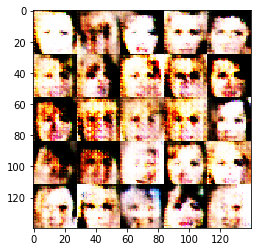

Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.6358
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.8996... Generator Loss: 0.3358
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.9087
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.8576


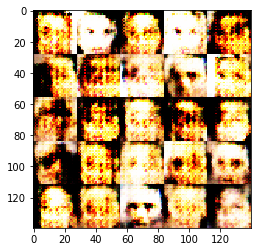

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.7059... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.1023


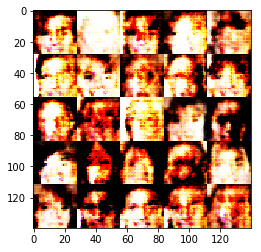

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 2.2442
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.9592


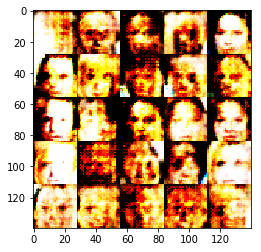

Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 2.2051
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 2.5738
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8717


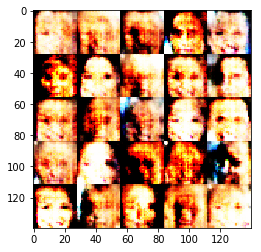

Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.4670
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.3795
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6104


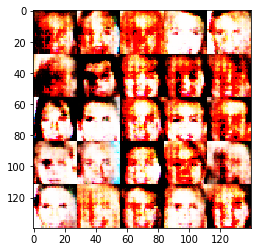

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8907


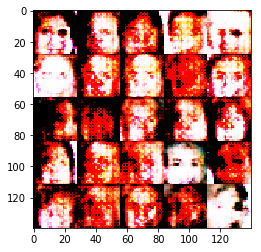

Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.9604


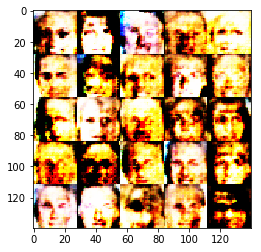

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7726


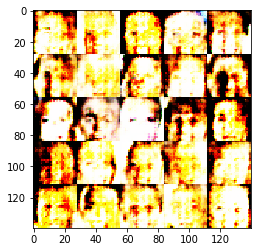

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 2.2662... Generator Loss: 3.3644
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.0587


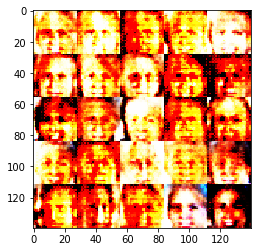

Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 2.1545
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.0543


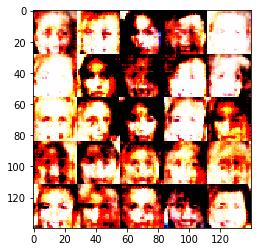

Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.7477
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.7693
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9880


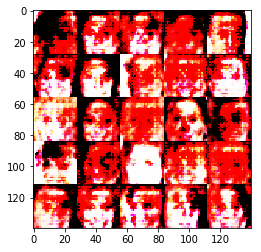

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 1.8717
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.7568... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.8805


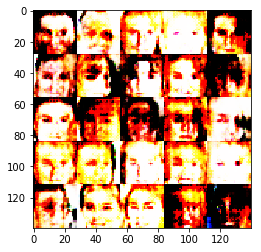

Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 2.5576
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.6683
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 1.9965
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.7317


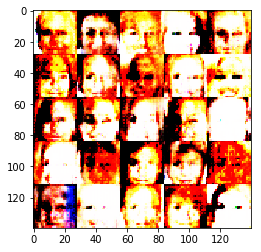

Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.8821
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.4142


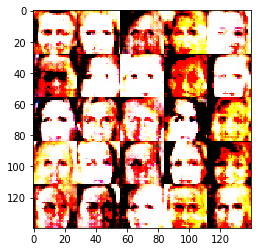

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.8163


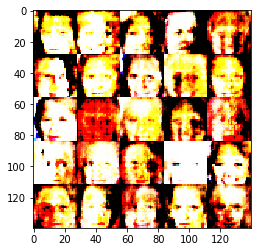

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6828


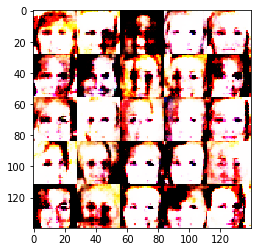

Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0872


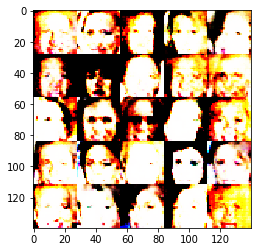

Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.7064


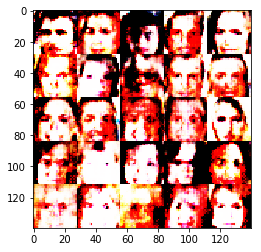

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.0727


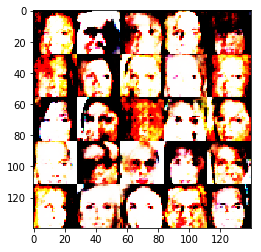

Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.7192... Generator Loss: 1.8771
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0285


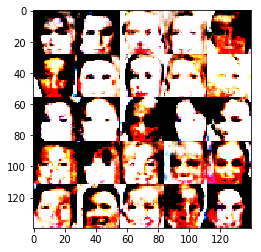

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.8271


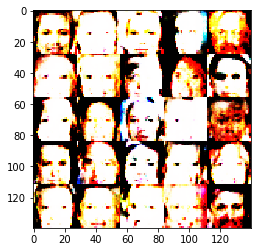

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.0426


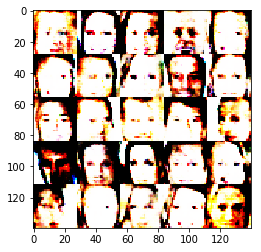

Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8918


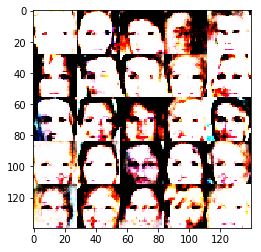

Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6928


IndexError: list index out of range

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.